## Text Mining II. Music Recomendation Based on Moods

#### Data Preparation

In [39]:
import nltk
import spacy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tree import Tree
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [40]:
nltk.download([
    "words",
    "punkt",
    "wordnet",
    "punkt_tab",
    "stopwords",
    "maxent_ne_chunker",
    "vader_lexicon",
])

[nltk_data] <urlopen error [Errno 11001] getaddrinfo failed>


False

In [41]:
FILE_PATH_EMOTION = './dataset/combined_emotion.csv'
FILE_PATH_SONG = './dataset/data_moods.csv'

In [42]:
df_emotion = pd.read_csv(FILE_PATH_EMOTION)
print(df_emotion.count(), '\n')
print(df_emotion["emotion"].unique(), '\n')
print(df_emotion.head(), '\n')

df_song = pd.read_csv(FILE_PATH_SONG)
print(df_song.head())

sentence    422746
emotion     422746
dtype: int64 

['fear' 'sad' 'love' 'joy' 'suprise' 'anger'] 

                                            sentence emotion
0      i just feel really helpless and heavy hearted    fear
1  ive enjoyed being able to slouch about relax a...     sad
2  i gave up my internship with the dmrg and am f...    fear
3                         i dont know i feel so lost     sad
4  i am a kindergarten teacher and i am thoroughl...    fear 

                                          name  ...       mood
0                                         1999  ...      Happy
1                                           23  ...        Sad
2                                     9 Crimes  ...        Sad
3                               99 Luftballons  ...      Happy
4  A Boy Brushed Red Living In Black And White  ...  Energetic

[5 rows x 19 columns]


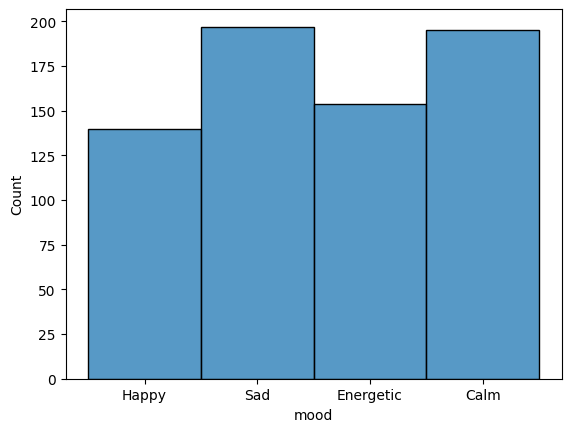

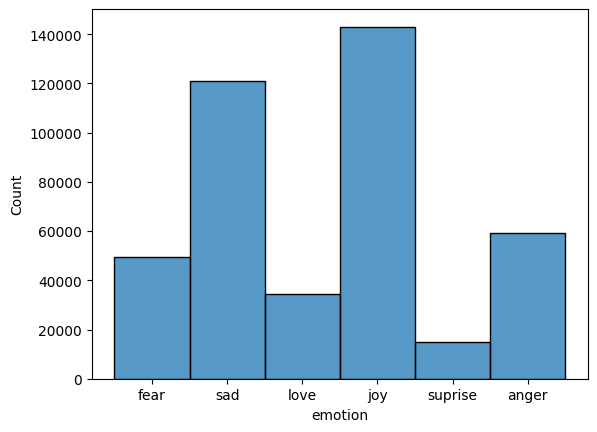

In [43]:
sns.histplot(df_song["mood"])
plt.show()
sns.histplot(df_emotion["emotion"])
plt.show()

### Data Processing

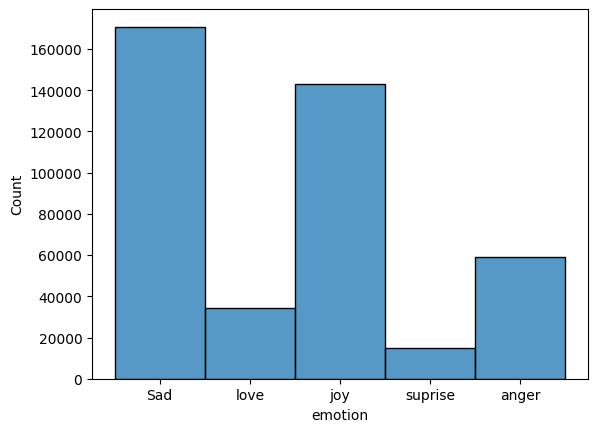

In [44]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'fear': 'Sad', 'sad': 'Sad'})
sns.histplot(df_emotion["emotion"])
plt.show()

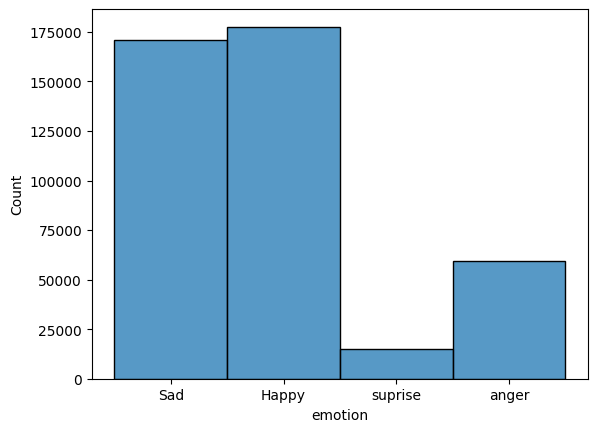

In [45]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'love': 'Happy','joy': 'Happy'})
sns.histplot(df_emotion["emotion"])
plt.show()

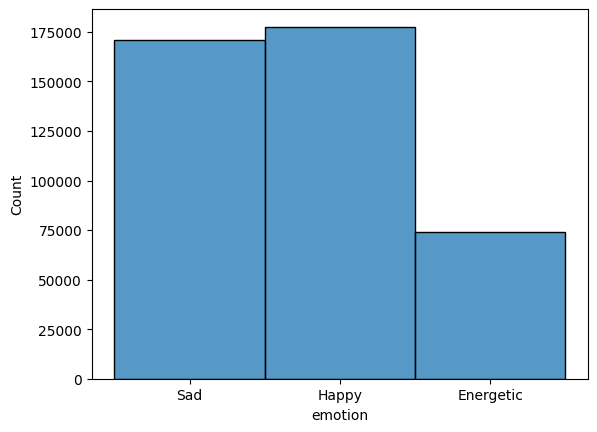

In [46]:
df_emotion['emotion'] = df_emotion['emotion'].replace({'suprise': 'Energetic','anger': 'Energetic'})
sns.histplot(df_emotion["emotion"])
plt.show()

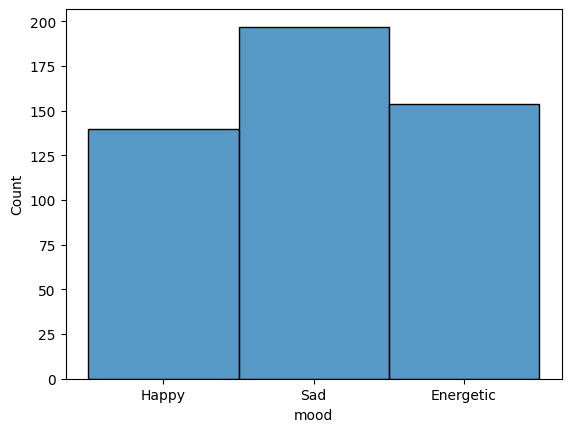

In [47]:
df_song['mood'] = df_song['mood'].drop(df_song[df_song['mood'] == 'Calm'].index)
sns.histplot(df_song["mood"])
plt.show()

### Model for Mood Analysis

##### Load & Process Dataset

In [48]:
sentence = df_emotion['sentence']
emotion = df_emotion['emotion']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    sentence,
    emotion,
    test_size=0.3,
    random_state=42
)

##### Compute TF-IDF Features

In [50]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

c:\1. BINUS\Programming Peripherals\Python environment\environments\machine_learning_3.10\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


##### Training Model

In [51]:
model = ComplementNB()
model.fit(
    X_train_tfidf, 
    y_train
)

ComplementNB()

              precision    recall  f1-score   support

   Energetic       0.91      0.79      0.84     22456
       Happy       0.95      0.98      0.96     53223
         Sad       0.92      0.94      0.93     51145

    accuracy                           0.93    126824
   macro avg       0.92      0.90      0.91    126824
weighted avg       0.93      0.93      0.93    126824

Accuracy: 92.92%
Labels present in y_test: ['Energetic', 'Happy', 'Sad']


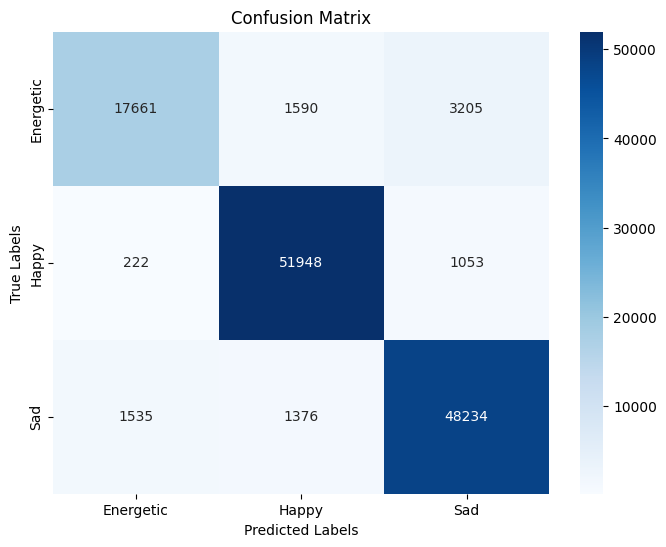

In [52]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
print(classification_report_result)
print(f'Accuracy: {accuracy*100:.2f}%')

print("Labels present in y_test:", sorted(set(y_test)))

confusionMatrix = confusion_matrix(y_test, y_pred)
class_labels = sorted(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Sample in Training

In [53]:
for sentence, true_label, predicted_label in zip(X_test[:10], y_test[:10], y_pred[:10]):
    print(f"User Input: {sentence}")
    print(f"True Mood: {true_label} | Predicted Mood: {predicted_label}")
    print("-" * 50)

User Input: i feel like i ve been convinced by some indian guys to go horseback riding with the dalton brothers in cappadocia
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i love the insular feel of island living how genuinely weird islanders are it seems to be a prerequisite that you have to be a little off kilter to choose living somewhere one can only access by boat and of course i love being surrounded by the ocean
True Mood: Sad | Predicted Mood: Energetic
--------------------------------------------------
User Input: i have a feeling that she wasnt thrilled
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i have to say since i am feeling so good about myself i have been making time to look more fashionable cute lately
True Mood: Happy | Predicted Mood: Happy
--------------------------------------------------
User Input: i feel deeply disturbed that young canadian unive

### Music Recomendation

In [54]:
def recommend_song(emotion, df_song, top_n=10):
    recommended_songs = df_song[df_song['mood'] == emotion].sort_values(by='popularity', ascending=False).head(top_n)[['name', 'album', 'artist', 'mood']]
    return recommended_songs

In [55]:
def predict_mood(user_input):
    user_input_tfidf = vectorizer.transform([user_input])
    return model.predict(user_input_tfidf)[0]

In [56]:
nlp = spacy.load("en_core_web_sm")
def extract_entities(text):
    doc = nlp(text)
    spacy.displacy.render(doc, style="ent", jupyter=True)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    return entities

### Menu Section

In [57]:
request = "NO REQUEST"
while True:
    print("\nMUSIC RECOMMENDATION APPLICATION BASED ON MOODS")
    print(f"YOUR REQUEST: {request}")
    print(f"YOUR MOOD: {'UNKNOWN' if request == 'NO REQUEST' else predict_mood(request).item()}")
    print("1. WRITE YOUR REQUEST")
    print("2. VIEW MUSIC RECOMMENDATION")
    print("3. VIEW NAMED ENTITIES RECOGNITION")
    print("4. EXIT")
    
    choice = input(">> ")
    
    if choice == "1":
        request = input("Enter your request: ")
    elif choice == "2":
        if request == "NO REQUEST":
            print("No request found. Please write a request first.")
        else:
            mood = predict_mood(request)
            print(f"Predicted Mood: {mood}")
            print("Recommended Songs:")
            print(recommend_song(mood, df_song))
    elif choice == "3":
        if request == "NO REVIEW":
            print("No request found. Please write a request first.")
            input("Press Enter to continue...")
        else:
            print("Named Entities:")
            extract_entities(request)
    elif choice == "4":
        print("Exiting...")
        break
    else:
        print("Invalid choice. Please select a valid option.")



MUSIC RECOMMENDATION APPLICATION BASED ON MOODS
YOUR REQUEST: NO REQUEST
YOUR MOOD: UNKNOWN
1. WRITE YOUR REQUEST
2. VIEW MUSIC RECOMMENDATION
3. VIEW NAMED ENTITIES RECOGNITION
4. EXIT
Exiting...
